# Heuristic Approaches for TSP

In [23]:
# first we install the requirements
%pip install pyscipopt networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


## Part 0: Generating and Visualizing a Random Instance

In order to run experiments, we need instances. 
For now, let us generate random instances by generating random coordinates in two dimensions.

In [24]:
import numpy as np

def random_tsp_instance(num_cities: int = 10, seed: int = 0) -> tuple:
    '''Create random TSP problem data'''

    # set of cities: 0..n-1
    CITIES = range(num_cities)  

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate random coordinates for cities
    X = 100 * np.random.rand(num_cities)
    Y = 100 * np.random.rand(num_cities)

    # Compute distance matrix
    dist = np.ceil(np.sqrt ((X.reshape(num_cities,1) - X.reshape(1,num_cities))**2 +
                            (Y.reshape(num_cities,1) - Y.reshape(1,num_cities))**2))
    
    return CITIES, X, Y, dist

CITIES, X, Y, dist = random_tsp_instance(10)


Let's check that our random instance looks interesting. 
Feel free to estimate the optimal tour by hand. 

We will directly add the option to pass the edges that will be the solution to the function. 
For now, we will only see the layout of the cities.

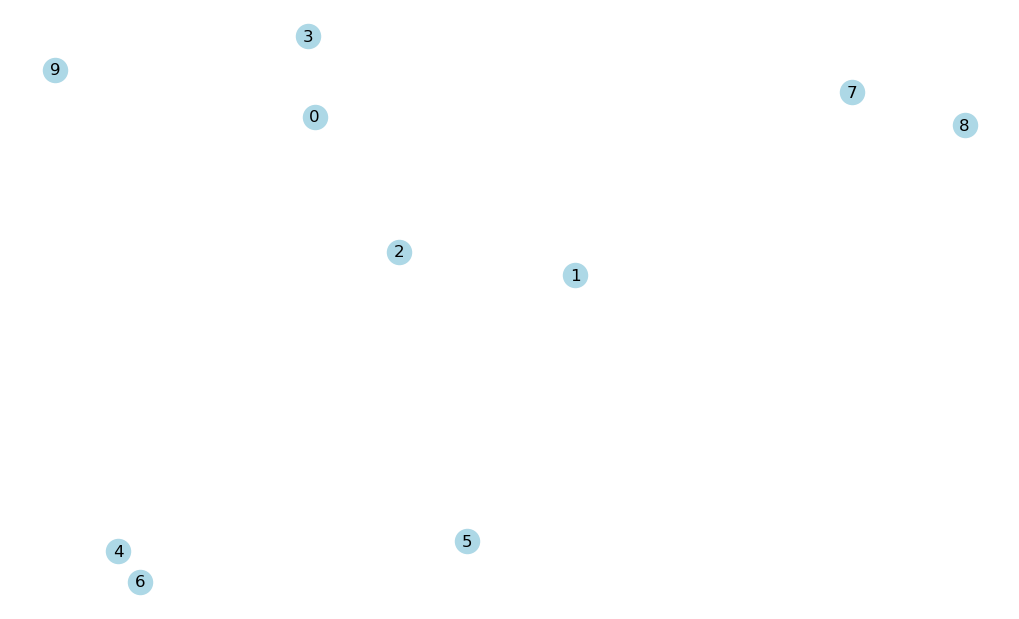

In [ ]:
# Visualize solution using networkx and matplotlib
import networkx as nx 
import matplotlib.pyplot as plt

def plot_sol(CITIES, X, Y, edges: list = []) -> None:
    '''Plot the solution of the TSP problem'''

    # create dictionary with coordinates for each node to plot the graph 
    xy = {}
    for i in CITIES:
        xy[i] = (X[i], Y[i])

    # make figure look nicer
    plt.figure(figsize=(10,6), dpi=100)

    # create empty graph
    optgraph = nx.Graph()

    # add edges
    optgraph.add_nodes_from(CITIES)  # add nodes
    optgraph.add_edges_from(edges)   # add edges

    # draw the nodes, with labels in the position xy (see when we read the instance)
    nx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

    # show drawing
    plt.show()

# Example usage of the plot_sol function
plot_sol(CITIES, X, Y) 

Let us quickly compute the optimal solution using linear programming in order to see how well our heuristics perform.
We use the MTZ formulation. 
For more information on this, we refer to the notebook on "Advanced Techniques for Solving the TSP."

presolving:
(round 1, fast)       11 del vars, 19 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 20 clqs
(round 2, exhaustive) 11 del vars, 19 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 20 upgd conss, 0 impls, 20 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 11 deleted vars, 19 deleted constraints, 0 added constraints, 10 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 72 implications, 20 cliques
presolved problem has 99 variables (90 bin, 0 int, 0 impl, 9 cont) and 92 constraints
     20 constraints of type <setppc>
     72 constraints of type <linear>
transformed objective value is always integral (scale: 1)
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/h

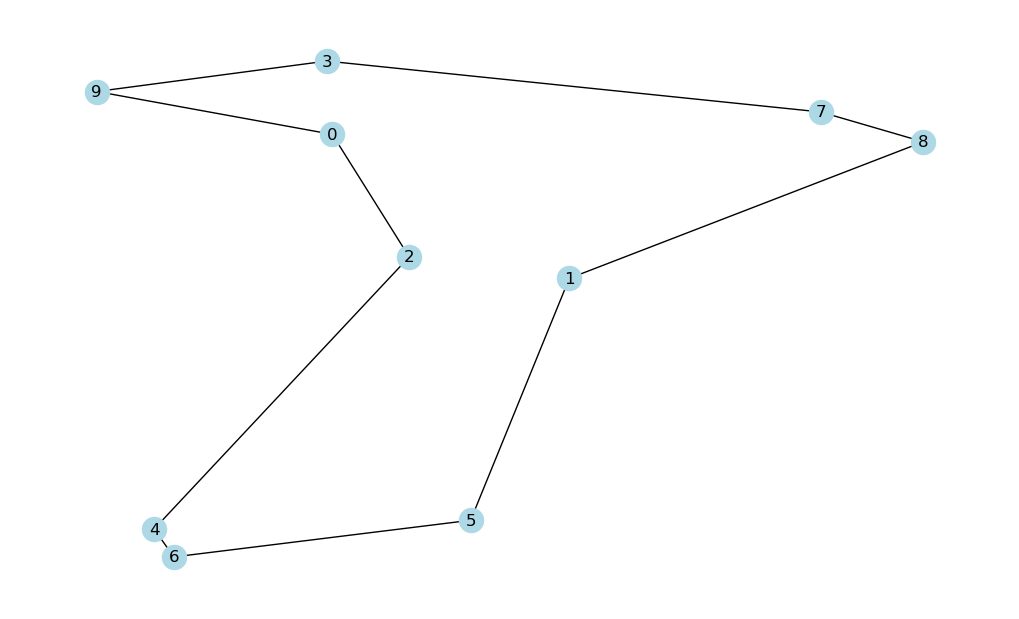

Optimal cost: 269.0


In [26]:
# SCIP - Python Interface

import itertools

# Get edges from the model solution
def get_solution_edges(model, CITIES, x):
    '''Extract edges from the model solution'''
    edges = []
    for (i, j) in itertools.permutations(CITIES, 2):
        if model.getVal(x[i, j]) > 0.5:  # variable is binary so > 0.5 --> is 1
            edges.append((i, j))
    return edges

num_cities = len(CITIES)

from pyscipopt import Model, quicksum
import numpy as np

# Create problem
model = Model()

# Create variables as a square matrix of binary variables. Note
# the use of p.addVariables to ensure NumPy uses the Xpress operations for handling these vectors.
x = {}
t = {}
for i in range(num_cities):
    for j in range(num_cities):
        x[i,j] = model.addVar(vtype="B", name='x[%i,%i]'%(i,j))
    t[i] = model.addVar(name='t[%i]'%i)

# Degree constraints
for i in CITIES:
    model.addCons(quicksum(x[i,j] for j in CITIES) == 1)
    model.addCons(quicksum(x[j,i] for j in CITIES) == 1)

# Fix diagonals (i.e. city X -> city X) to zero
for i in CITIES:
    model.addCons(x[i,i] == 0)

# Miller, Tucker, Zemlin subtour elimination constraints
for i in range(1, num_cities):
    for j in range(1, num_cities):
        model.addCons(t[j] >= t[i] + 1 - num_cities * (1 - x[i,j]))

# Objective function
model.setObjective(quicksum(dist[i,j]*x[i,j] for i in range(num_cities) for j in range(num_cities)))

model.optimize()

# Plot solution
if model.getNSols() == 0:
    print("No feasible solution found.")
else:
    # collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
    edges = get_solution_edges(model, CITIES, x)

    plot_sol(CITIES, X, Y, edges)  # print solution and cost

    optimal_cost = model.getObjVal()
    print(f"Optimal cost: {optimal_cost}")

Let us also write a simple function to compute the length of a tour given the edges contained in the tour. 

In [27]:
def compute_cost(edges, dist):
    '''Compute the total cost of the tour given the edges and distance matrix'''
    cost = 0
    for (i, j) in edges:
        cost += dist[i, j]
    return cost

## Heuristic 1: Nearest Neighbor

The Nearest Neighbor heuristic is a simple and fast algorithm for solving the Traveling Salesman Problem (TSP). 
Starting from a chosen city, it repeatedly visits the nearest unvisited city until all cities are visited, then returns to the starting city. 
While it does not guarantee the optimal solution, it often produces a reasonable tour quickly and is useful for generating initial solutions or for small instances.

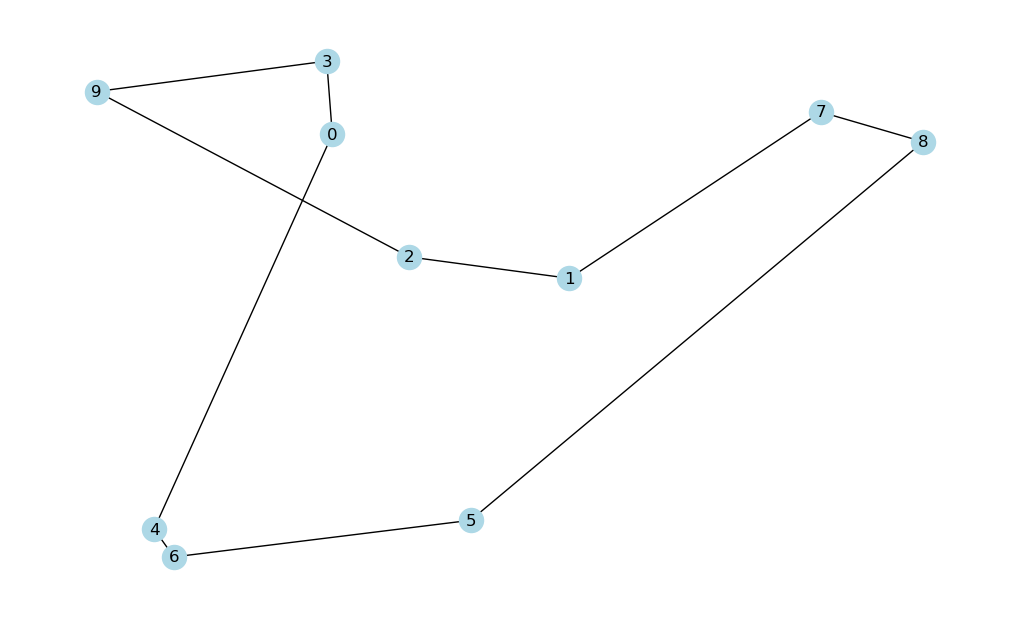

Nearest Neighbor tour cost: 307.0
Optimal cost from SCIP: 269.0
Percentage difference between optimal and nearest neighbor cost: 14.13%


In [28]:
def tsp_nearest_neighbor(CITIES, dist, start=0):
    '''Nearest Neighbor heuristic for TSP'''

    n = len(CITIES)
    unvisited = set(CITIES)
    tour = [start]
    unvisited.remove(start)
    current = start

    while unvisited:
        next_city = min(unvisited, key=lambda city: dist[current, city])
        tour.append(next_city)
        unvisited.remove(next_city)
        current = next_city

    # Return to start to complete the tour
    tour.append(start)
    return tour

# Run the heuristic
nn_tour = tsp_nearest_neighbor(CITIES, dist)

# Convert tour to edge list for plotting
nn_edges = [(nn_tour[i], nn_tour[i+1]) for i in range(len(nn_tour)-1)]

# Plot the solution
plot_sol(CITIES, X, Y, nn_edges)

# Compute the cost of the nearest neighbor tour
nn_cost = compute_cost(nn_edges, dist)
print(f"Nearest Neighbor tour cost: {nn_cost}")
print(f"Optimal cost from SCIP: {optimal_cost}")

# Compute percentage difference
percentage_difference = abs(((optimal_cost - nn_cost) / optimal_cost)) * 100
print(f"Percentage difference between optimal and nearest neighbor cost: {percentage_difference:.2f}%")

## Heuristic 2: Furthest Insetion

The Furthest Insertion heuristic is a constructive algorithm for the Traveling Salesman Problem (TSP). 
It begins by identifying the two cities that are the furthest apart and initializes a subtour with these cities. 
At each step, the algorithm selects the unvisited city that is furthest from any city currently in the tour. 
This city is then inserted into the position in the tour that results in the smallest possible increase in the total tour length. 
The process repeats until all cities are included in the tour.
While not guaranteed to find the optimal solution, the Furthest Insertion heuristic often produces high-quality tours and is particularly effective for instances where cities are spread out.

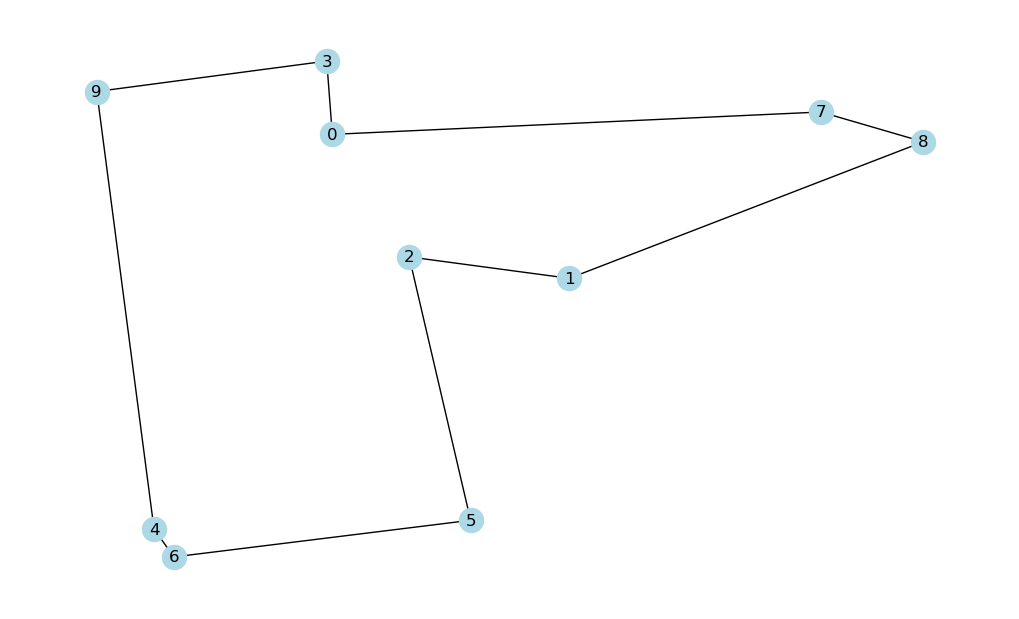

Furthest Insertion tour cost: 282.0
Optimal cost from SCIP: 269.0
Percentage difference between optimal and furthest insertion cost: 4.83%


In [29]:
def tsp_furthest_insertion(CITIES, dist):
    '''Furthest Insertion heuristic for TSP'''

    n = len(CITIES)
    unvisited = set(CITIES)

    # Start with the two cities that are furthest apart
    max_dist = -1
    for i in CITIES:
        for j in CITIES:
            if i != j and dist[i, j] > max_dist:
                max_dist = dist[i, j]
                start, next_city = i, j

    tour = [start, next_city, start]
    unvisited.remove(start)
    unvisited.remove(next_city)

    while unvisited:
        # Find the unvisited city furthest from any city in the tour
        furthest_city = max(
            unvisited,
            key=lambda city: min(dist[city, t] for t in tour[:-1])
        )

        # Find the best place to insert the furthest city into the tour
        best_pos = None
        min_increase = float('inf')
        for i in range(len(tour) - 1):
            a, b = tour[i], tour[i + 1]
            increase = dist[a, furthest_city] + dist[furthest_city, b] - dist[a, b]
            if increase < min_increase:
                min_increase = increase
                best_pos = i + 1

        tour.insert(best_pos, furthest_city)
        unvisited.remove(furthest_city)

    return tour

# Run the heuristic
fi_tour = tsp_furthest_insertion(CITIES, dist)

# Convert tour to edge list for plotting
fi_edges = [(fi_tour[i], fi_tour[i+1]) for i in range(len(fi_tour)-1)]

# Plot the solution
plot_sol(CITIES, X, Y, fi_edges)

# Compute the cost of the furthest insertion tour
fi_cost = compute_cost(fi_edges, dist)
print(f"Furthest Insertion tour cost: {fi_cost}")
print(f"Optimal cost from SCIP: {optimal_cost}")

# Compute percentage difference
percentage_difference_fi = abs(((optimal_cost - fi_cost) / optimal_cost)) * 100
print(f"Percentage difference between optimal and furthest insertion cost: {percentage_difference_fi:.2f}%")

## Heuristic 3: 2-opt

The 2-opt heuristic is a popular local search algorithm for improving solutions to the Traveling Salesman Problem (TSP). 
Starting from an initial tour, the 2-opt method iteratively examines all possible pairs of edges and swaps them if the swap results in a shorter tour. 
This process continues until no further improvements can be made. 
While 2-opt does not guarantee an optimal solution, it is simple to implement and often produces significant improvements over greedy or constructive heuristics.

Initial tour (random):


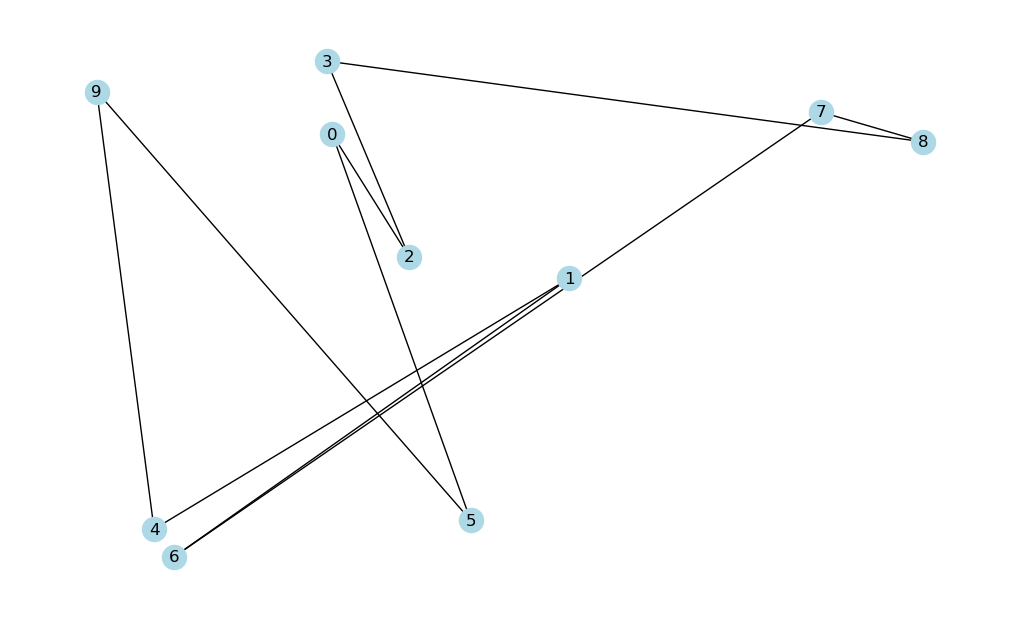

Improved tour after 2-opt:


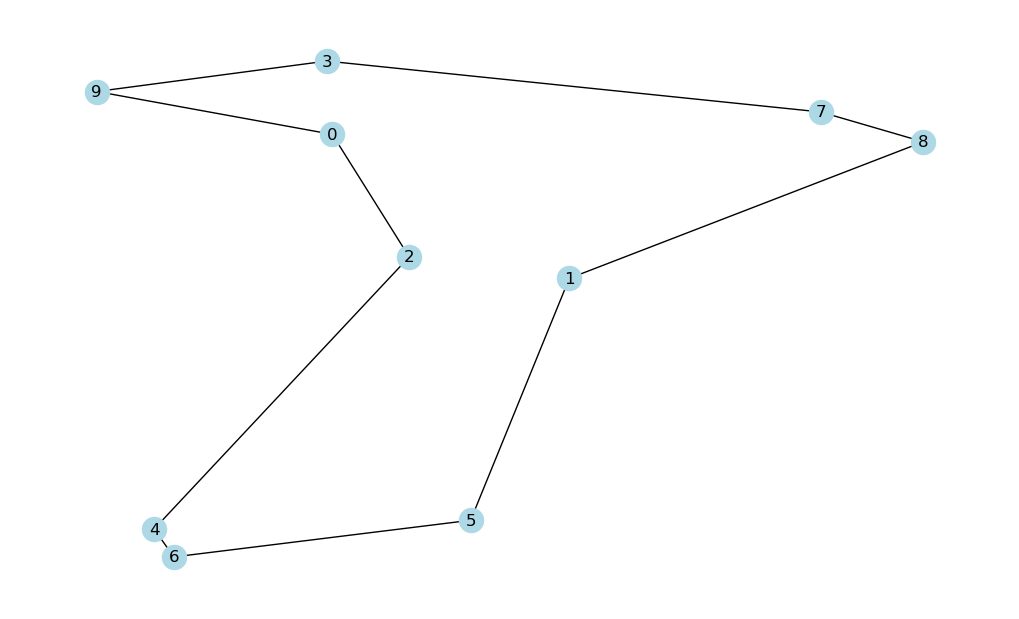

2-opt tour cost: 269.0
Optimal cost from SCIP: 269.0
Percentage difference between optimal and 2-opt cost: 0.00%


In [41]:
def tsp_2opt(tour, dist):
    '''2-opt heuristic for TSP: improves a given tour by iteratively swapping edges'''

    best = tour[:]
    improved = True
    n = len(tour)
    
    while improved:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                # Calculate the cost difference if we swap edges (i-1,i) and (j,j+1)
                a, b = best[i - 1], best[i]
                c, d = best[j], best[j + 1]
                delta = (dist[a, c] + dist[b, d]) - (dist[a, b] + dist[c, d])
                if delta < 0:
                    # Perform the 2-opt swap
                    best[i:j + 1] = best[i:j + 1][::-1]
                    improved = True
        # Optionally, break early if no improvement
        if not improved:
            break
    return best

# Initialize a random tour
initial_tour = list(CITIES)
np.random.shuffle(initial_tour)

# Add the starting city to complete the tour
initial_tour.append(initial_tour[0])

# Plot the improved tour
print("Initial tour (random):")
initial_edges = [(initial_tour[i], initial_tour[i+1]) for i in range(len(initial_tour)-1)]
plot_sol(CITIES, X, Y, initial_edges)

# Run 2-opt starting from the nearest neighbor tour
opt_tour = tsp_2opt(initial_tour, dist)

# Convert tour to edge list for plotting
opt_edges = [(opt_tour[i], opt_tour[i+1]) for i in range(len(opt_tour)-1)]

# Plot the improved tour
print("Improved tour after 2-opt:")
plot_sol(CITIES, X, Y, opt_edges)

# Compute the cost of the 2-opt tour
opt_cost = compute_cost(opt_edges, dist)
print(f"2-opt tour cost: {opt_cost}")
print(f"Optimal cost from SCIP: {optimal_cost}")

# Compute percentage difference
percentage_difference_opt = abs(((optimal_cost - opt_cost) / optimal_cost)) * 100
print(f"Percentage difference between optimal and 2-opt cost: {percentage_difference_opt:.2f}%")